<a href="https://colab.research.google.com/github/oriheldman/eurovision_social_analysis/blob/main/data_collection_clean_prepro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Eurovision and Trade Graphs

This section builds a graph for both the eurovision and the trade between the countries. 

Eurovision graph for each year - a directed graph, each node is a country participating, an edge from node i to node j exsists if country i gave points to country j. The weight of that edge is the normalized points country i gave to j.

Trade graph for each year - a directed graph, each node is a country (**participating in the eurovision in the same year), an edge from node i to node j exsists if country i exports to country j (if j is in the top 12 exported countries of i). The weight of that edge is the normalized export of all goods country i gave to j.

###Imports and drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount()

In [ ]:
import numpy as np 
import pandas as pd 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
import re
import random
import json
import functools


#visualization libs
%matplotlib inline
#%config InlineBackend.figure_format ='retina'

import pylab as plt
import seaborn as sns
sns.set_style('whitegrid')
from ipywidgets.widgets import HTML
from tqdm import tqdm


#graph and network libs
import networkx as nx
import community as louvain


#machine learning libs
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn import decomposition, manifold

from gensim.models import Word2Vec

##Eurovision Graphs

### Eurovision dataset - load and clean 

In [ ]:
eurovison_df = pd.read_csv('/content/drive/MyDrive/NLP-SD/Data/eurovision_votes_1975_2021.csv')
eurovison_df.columns = ['year','final','edition','votetype','countryfrom','countryto','points','duplicate']

In [ ]:
# removing empty edges, duplicates and countries with few participations

def clean_data(eurovison_df, min_years = 5, last_participation=8):
    """
    eurovison_df: the original eurovision dataset
    min_year: minimum years of participations
    last_participation: has participated in the last x years
    """
    eurovison_df = eurovison_df.copy().query('points > 0')
    
    #Removing duplicates
    eurovison_df['duplicate'] = eurovison_df['duplicate'].apply(lambda x: True if x == 'x' or x==True else False)
    eurovison_df = eurovison_df.query('duplicate == False').drop(columns=['duplicate'])

    
    #Stantardazing countries names.
    def rename_country(x):
        renamings ={
            'North Macedonia':'Macedonia',
            'F.Y.R. Macedonia':'Macedonia',
            'The Netherands': 'Netherlands',
            'The Netherlands':'Netherlands',
            'Bosnia & Herzegovina':'Bosnia',
        }
        return renamings[x] if x in renamings else x

    eurovison_df['countryfrom'] = eurovison_df['countryfrom'].apply(rename_country)
    eurovison_df['countryto']   = eurovison_df['countryto'].apply(rename_country)

    #replicating  Yugoslavia's results to countries that part of it.
    division = {
        'Yugoslavia':['Macedonia','Serbia','Montenegro','Slovenia','Bosnia','Croatia'],
        'Serbia & Montenegro':['Serbia','Montenegro'],
    }
    
    eurovison_df['countryfrom'] = eurovison_df['countryfrom'].apply(lambda x:division[x] if x in division else x)
    eurovison_df['countryto']   = eurovison_df['countryto'].apply(lambda x:division[x] if x in division else x)
    eurovison_df = eurovison_df.explode('countryfrom').explode('countryto')
    

    # removing countries with less then x participations and not active in the last x years
    toKeep = eurovison_df.groupby('countryfrom').apply(
        lambda x:pd.Series({
            'years':x['year'].nunique(),
            'last_participation':eurovison_df['year'].max() - x['year'].max(),
            })).query(f'years >= {min_years} and last_participation <= {last_participation}').reset_index()['countryfrom'];
    
    display(HTML("<p>ignored countries: %s</p>" %', '.join(eurovison_df[eurovison_df['countryfrom'].isin(toKeep)==False]['countryfrom'].unique())))

    eurovison_df = eurovison_df[eurovison_df['countryfrom'].isin(toKeep)]
    eurovison_df = eurovison_df[eurovison_df['countryto'].isin(toKeep)]
    
    
    #keep only the points received at the highest stage (finals/semifinals)
    eurovison_df['finalcode']=eurovison_df.final.map({'f':1,'sf':2,'sf1':2,'sf2':2})
    temp1 = eurovison_df.groupby(['countryto','year']).agg({'finalcode':'min'});
    eurovison_df = pd.merge(eurovison_df,temp1, on=['countryto','year','finalcode'], how='inner')
    
    assert len(eurovison_df.groupby(['countryfrom','countryto','year']).agg({'final':'nunique'}).query('final >1')) == 0
    
    eurovison_df.drop(columns=['finalcode','edition'], inplace=True)
    
    return eurovison_df.reindex()

eurovison_df_c = clean_data(eurovison_df);
eurovison_df_c["normalized_points"] = eurovison_df_c['points'].apply(lambda point: point/57)

In [ ]:
#use these function to filter out only the top N with most of point by countries
# or Top %percent of cumsum (useful for Pareto analysis).


def selectTopN(x,column, top=3):
    x = x.sort_values(column).tail(top)
    return x;

def selectTopPercent(x, column, percent=0.2, retrieve_first=True):
    x = x.sort_values(column, ascending=False)
    cut = x[column].cumsum() / x[column].sum();
    cut = cut <= percent;
    
    #return at least the first and avoid warnings
    if retrieve_first and cut.sum() ==0:
        return x.iloc[0];
    
    return x[cut==True];

def plot(g, title, ax=None):
  if ax == None:
      ax = plt.gca();
      
  ax.set_title(title);
  
  np.random.seed(12)
  pos=nx.kamada_kawai_layout(g,weight='weight');
  nx.draw(g,
      pos = pos,
      ax=ax,
      cmap=plt.cm.viridis_r,
      edge_color='#cccccc',
      node_color=list(nx.pagerank(g).values()),
      font_color='#000',
      with_labels=True,
  )

### Creating Eurovision Graphs

The following code will create a eurovision graph as discribed above for each year from 2015-2021 for countries in the final (2020 not included COVID-19 year). 

In [ ]:
def create_vote_graph():
  for year in range(2015, 2022):
    if year != 2020:
      for vote_type in ['T', 'J', 'J_T']:
        if year == 2015:
          eurovison_data = eurovison_df_c.query("year == {} and final == 'f' and votetype == 'J'".format(year))
        else:
          if vote_type == 'J_T':
            eurovison_data = eurovison_df_c.query("year == {} and final == 'f'".format(year))
            # sum both jury and televoters
            eurovison_data = eurovison_data.groupby(['countryfrom','countryto']).agg({'points':'sum'}).reset_index()
            eurovison_data["normalized_points"] = eurovison_data['points'].apply(lambda point: point/114)
          else:
            eurovison_data = eurovison_df_c.query("year == {} and final == 'f' and votetype == '{}'".format(year, vote_type))
        eurovison_data = eurovison_data.groupby(['countryfrom']).apply(selectTopN,'normalized_points',12).reset_index(drop=True)
        euro_vote_graph = nx.from_pandas_edgelist(eurovison_data,'countryfrom','countryto',['normalized_points'], create_using=nx.OrderedDiGraph)
        nx.write_gpickle(euro_vote_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/euro_votes_graph_{}_{}.gpickle".format(year, vote_type))

create_vote_graph()

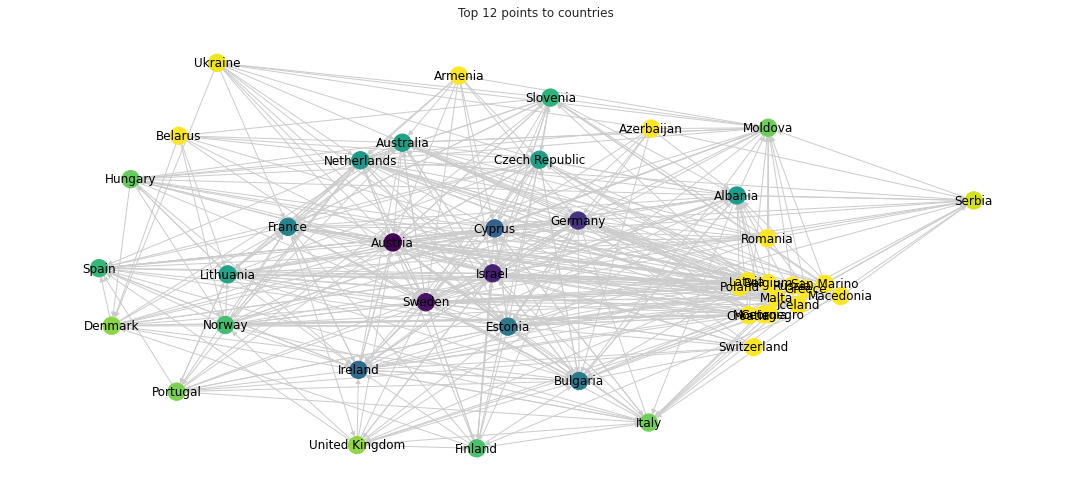

In [ ]:
#  Plotting exapmle of eurovision jury votes 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/euro_votes_graph_2018_J.gpickle")
plot(G,title='Top 12 points to countries',ax=plt.gca())
plt.tight_layout();

##Trade Graphs

### WITO export import data

An edge from A to B represents country A exporting goods to country B (or B importing from A). The weight of the this edge is proportinal to the magnitude of the trade both export and import. We compute the magnitude of trade w_edge = (0.5 * export) + (0.5 * import)

In [ ]:
# collecting trade data from WITS for all eurovision countries - helpfull lists:wits.get_products()wits.get_indicators()['definition']

# !pip install world_trade_data
import world_trade_data as wits
all_eurovision_countries = list(eurovison_df_c['countryfrom'].unique())

year_start = 2013

In [ ]:
def create_wito_data():
  wits_country_data = pd.read_csv('/content/drive/MyDrive/NLP-SD/Data/WITS_data/wits_country_data.csv')
  for country in all_eurovision_countries:
    year_end = 2020
    print(country)
    id_name = country
    if country == "Macedonia":
      country = "North Macedonia"
    elif country == "Serbia":
      country = "Serbia, FR(Serbia/Montenegro)"
    elif country == "Montenegro":
      year_end = 2019
    elif country =="Bosnia":
      country = "Bosnia and Herzegovina"
    elif country =="Russia":
      country = "Russian Federation"
    elif country == "Ukraine":
      year_end = 2019
    elif country == "San Marino":
      continue
    for year in range(year_start, year_end):
      country_code = wits_country_data.loc[wits_country_data['name'] == str(country), 'iso3Code'].iloc[0]
      exports = wits.get_indicator('XPRT-TRD-VL', reporter=country_code, partner="all",product="Total", year=str(year))
      exports.to_csv('/content/drive/MyDrive/NLP-SD/Data/WITS_data/{}_{}_exp.csv'.format(id_name, year))

create_wito_data()

In [ ]:
# creating a united dataset of trade - calculating precentage of trade
year_end = 2019
cols = ["Reporter", "Partner", "Year", "Value"]
all_trade_data = pd.DataFrame(columns=cols+["Share"])
for country in all_eurovision_countries:
  if country == "Montenegro":
    year_end = 2019
  elif country == "Ukraine":
    year_end = 2019
  elif country == "San Marino":
    continue
  for year in range(2013, year_end):
    trade_data = pd.read_csv('/content/drive/MyDrive/NLP-SD/Data/WITS_data/{}_{}_exp.csv'.format(country, year))[cols]
    world_val = trade_data.loc[trade_data['Partner'] == "World", 'Value'].iloc[0]
    trade_data["Share"] = trade_data["Value"].apply(lambda val: val/world_val)
    all_trade_data = all_trade_data.append(trade_data, ignore_index = True)

all_trade_data.loc[all_trade_data['Partner'] == "Macedonia, FYR", 'Partner'] = "Macedonia"
all_trade_data.loc[all_trade_data['Partner'] == "Serbia, FR(Serbia/Montenegro)", 'Partner'] = "Serbia"
all_trade_data.loc[all_trade_data['Partner'] == "Bosnia and Herzegovina", 'Partner'] = "Bosnia"
all_trade_data.loc[all_trade_data['Partner'] == "Russian Federation", 'Partner'] = "Russia"

all_trade_data.loc[all_trade_data['Reporter'] == "Macedonia, FYR", 'Reporter'] = "Macedonia"
all_trade_data.loc[all_trade_data['Reporter'] == "Serbia, FR(Serbia/Montenegro)", 'Reporter'] = "Serbia"
all_trade_data.loc[all_trade_data['Reporter'] == "Bosnia and Herzegovina", 'Reporter'] = "Bosnia"
all_trade_data.loc[all_trade_data['Reporter'] == "Russian Federation", 'Reporter'] = "Russia"


# remove all World partners
all_trade_data = all_trade_data[all_trade_data["Partner"] != "World"]
all_trade_data.to_csv('/content/drive/MyDrive/NLP-SD/Data/eurvis_countries_trade_data.csv')


In [ ]:
all_trade_data.query('Partner in @all_eurovision_countries and Year == 2013'.format(year))

In [ ]:
# all_eurovision_countries = list(eurovison_df_c['countryfrom'].unique())
year = 2013
list(eurovison_df.query('final == "f" and year == {}'.format(year))['countryto'].unique())
# eurovison_df_c


In [ ]:
all_eurovision_countries = list(eurovison_df_c['countryfrom'].unique())

def create_trade_graph():
  for year in range(year_start, 2019):
    print(year)
    trade_data = all_trade_data.query('Partner in @all_eurovision_countries and Year == {}'.format(year))
    # trade_data = trade_data.groupby(['Reporter']).apply(selectTopN,'Share',12).reset_index(drop=True)
    euro_trade_graph = nx.from_pandas_edgelist(trade_data,'Reporter','Partner',['Share'], create_using=nx.OrderedDiGraph)
    nx.write_gpickle(euro_trade_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_all{}.gpickle".format(year))


def create_trade_graph_final():
  for year in range(year_start, 2019):
    print(year)
    final_c = list(eurovison_df.query('final == "f" and year == {}'.format(year))['countryto'].unique())
    trade_data = all_trade_data.query('Partner in @final_c and Year == {}'.format(year))
    # trade_data = trade_data.groupby(['Reporter']).apply(selectTopN,'Share',12).reset_index(drop=True)
    euro_trade_graph = nx.from_pandas_edgelist(trade_data,'Reporter','Partner',['Share'], create_using=nx.OrderedDiGraph)
    nx.write_gpickle(euro_trade_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_final_{}.gpickle".format(year))


create_trade_graph()
create_trade_graph_final()

2013
2014
2015
2016
2017
2018
2013
2014
2015
2016
2017
2018


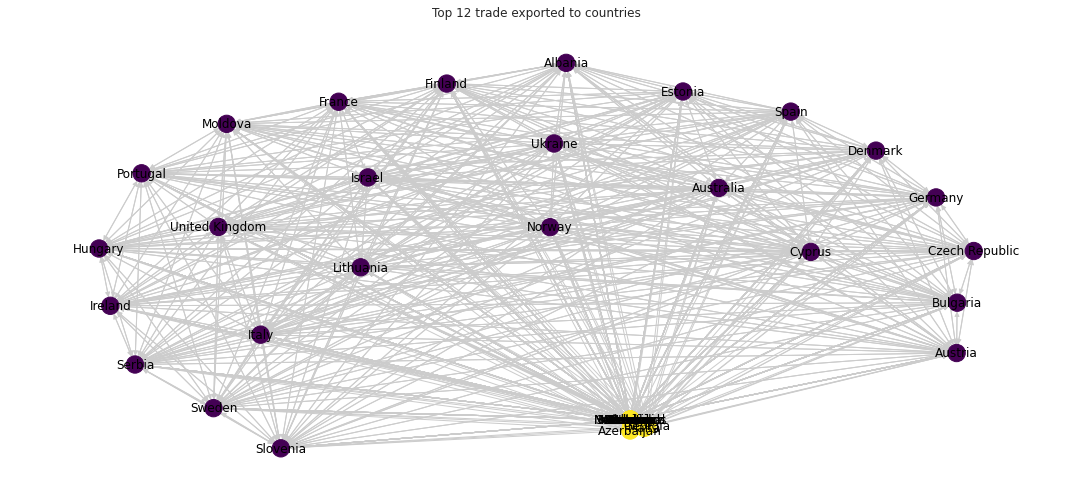

In [ ]:
#  Plotting exapmle of euro trade 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G_all = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_final_2018.gpickle")
plot(G_all,title='Top 12 trade exported to countries',ax=plt.gca())
plt.tight_layout();

In [ ]:
for n, d in G_all.in_degree:
  print(n, d)

Belgium 0
Albania 41
Australia 42
Austria 42
Bulgaria 42
Cyprus 42
Czech Republic 42
Germany 42
Denmark 42
Spain 42
Estonia 42
Finland 42
France 42
United Kingdom 42
Hungary 42
Ireland 42
Israel 42
Italy 42
Lithuania 42
Moldova 41
Norway 42
Portugal 41
Serbia 42
Slovenia 42
Sweden 42
Ukraine 42
Malta 0
Switzerland 0
Netherlands 0
Macedonia 0
Montenegro 0
Bosnia 0
Croatia 0
Greece 0
Iceland 0
Poland 0
Russia 0
Romania 0
Latvia 0
Belarus 0
Armenia 0
Georgia 0
Azerbaijan 0


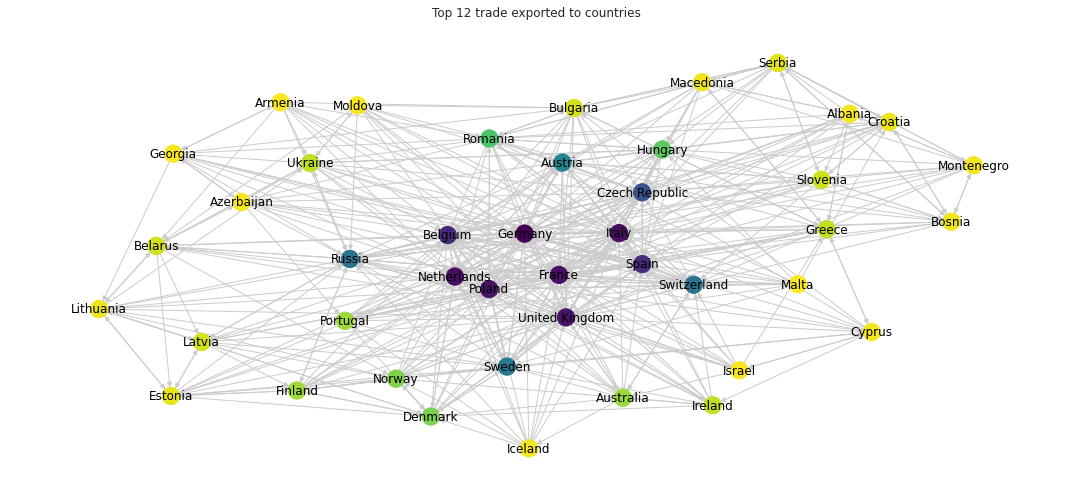

In [ ]:
#  Plotting exapmle of euro trade 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_2018.gpickle")
plot(G,title='Top 12 trade exported to countries',ax=plt.gca())
plt.tight_layout();

In [ ]:
for n, d in G.in_degree:
  print(n, d)

Albania 2
Slovenia 6
France 36
Netherlands 35
Czech Republic 23
Romania 16
Montenegro 3
Macedonia 4
Greece 6
Germany 42
Spain 29
Serbia 7
Italy 37
Armenia 1
Belarus 5
Ukraine 8
Belgium 27
Georgia 2
Bulgaria 8
Switzerland 19
Russia 23
Australia 5
Sweden 18
Iceland 1
Poland 32
United Kingdom 33
Austria 15
Hungary 12
Azerbaijan 2
Portugal 4
Israel 2
Estonia 4
Norway 10
Latvia 4
Lithuania 4
Bosnia 4
Croatia 5
Cyprus 2
Ireland 3
Denmark 10
Finland 6
Malta 0
Moldova 1


#Tourisem Data

##Clean and Preprocess data

In [ ]:
tour_country_data = pd.read_excel('/content/drive/MyDrive/NLP-SD/Data/TOUR_EU_2013_2019.xlsx', header=[0,1], index_col=[0] ).dropna(axis=1, how='all').replace(":", 0)

In [ ]:
# tour_country_data['2013'][all_eurovision_countries]
# len([c for c in all_eurovision_countries if c in tour_country_data['2013'].columns])

def create_tour_dataset_for_graph(tour_df, years_list, all_eurovision_countries):
  """
  years_list - list of years as strings 
  """
  for year in years_list:
    f = [c for c in all_eurovision_countries if c in tour_df[year].columns]
    curr = tour_df[year][f + ["sum"]]
    curr = curr.div(curr["sum"], axis = 0).fillna(0).reset_index()
    curr = pd.melt(curr, id_vars=['index'], value_vars=f)
    curr = curr[curr['index'] != curr['PARTNER (Labels)']]
    curr.columns = ["reporter", "partner", "weight"]
    curr = curr.reset_index(drop = True)
    curr.to_csv("/content/drive/MyDrive/NLP-SD/Data/tour_data/tour_{}".format(year))


years_list = [str(a) for a in range(2013,2020)]
create_tour_dataset_for_graph(tour_country_data, years_list, all_eurovision_countries)


## Create Tourist Graph

In [ ]:
tour_data = pd.read_csv("/content/drive/MyDrive/NLP-SD/Data/tour_data/tour_{}".format(2014))
tour_data.groupby(['reporter']).apply(selectTopN,'weight',12)

Unnamed: 0        reporter         partner    weight
reporter                                                                 
Albania        361          361         Albania         Finland  0.000000
               328          328         Albania  United Kingdom  0.000000
               295          295         Albania     Netherlands  0.000000
               262          262         Albania     Switzerland  0.000000
               229          229         Albania          Sweden  0.000000
               196          196         Albania           Spain  0.000000
               163          163         Albania        Portugal  0.000000
               130          130         Albania           Malta  0.000000
               97            97         Albania           Italy  0.000000
               64            64         Albania         Ireland  0.000000
               493          493         Albania         Croatia  0.000000
               1025        1025         Albania       Australia  0.000000
Austria        18            18         Austria         Belgium  0.006501
               779          779         Austria          Poland  0.008900
               448          448         Austria        Slovenia  0.010817
               250          250         Austria     Switzerland  0.013489
               316          316         Austria  United Kingdom  0.014354
               845          845         Austria         Hungary  0.014709
               579          579         Austria          Greece  0.016929
               381          381         Austria          France  0.017904
               183          183         Austria           Spain  0.025341
               480          480         Austria         Croatia  0.048297
               84            84         Austria           Italy  0.090471
               513          513         Austria         Germany  0.104438
Belgium        33            33         Belgium         Ireland  0.005496
               760          760         Belgium          Poland  0.006378
               231          231         Belgium     Switzerland  0.013243
               132          132         Belgium        Portugal  0.016779
               528          528         Belgium         Austria  0.017718
               561          561         Belgium          Greece  0.022548
               297          297         Belgium  United Kingdom  0.032848
               495          495         Belgium         Germany  0.052929
               66            66         Belgium           Italy  0.057258
               264          264         Belgium     Netherlands  0.078037
               165          165         Belgium           Spain  0.088284
               363          363         Belgium          France  0.278151
Bulgaria       265          265        Bulgaria     Netherlands  0.001243
               100          100        Bulgaria           Malta  0.001766
               0              0        Bulgaria         Belgium  0.001936
               794          794        Bulgaria          Russia  0.002262
               861          861        Bulgaria         Romania  0.002485
               364          364        Bulgaria          France  0.003597
               166          166        Bulgaria           Spain  0.004017
               529          529        Bulgaria         Austria  0.004207
               298          298        Bulgaria  United Kingdom  0.008476
               67            67        Bulgaria           Italy  0.009594
               496          496        Bulgaria         Germany  0.010118
               562          562        Bulgaria          Greece  0.045152
Croatia        770          770         Croatia          Poland  0.003975
               570          570         Croatia          Greece  0.004882
               241          241         Croatia     Switzerland  0.005219
               274          274         Croatia     Netherlands  0.005485
               307       

In [ ]:
def create_tour_graph(years_list):
  for year in years_list:
    tour_data = pd.read_csv("/content/drive/MyDrive/NLP-SD/Data/tour_data/tour_{}".format(year))
    tour_data = tour_data.groupby(['reporter']).apply(selectTopN,'weight',12).reset_index(drop=True)
    tour_graph = nx.from_pandas_edgelist(tour_data,'reporter','partner',['weight'], create_using=nx.OrderedDiGraph)
    nx.write_gpickle(tour_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/tour_graph_{}.gpickle".format(year))

create_tour_graph(years_list)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:739: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


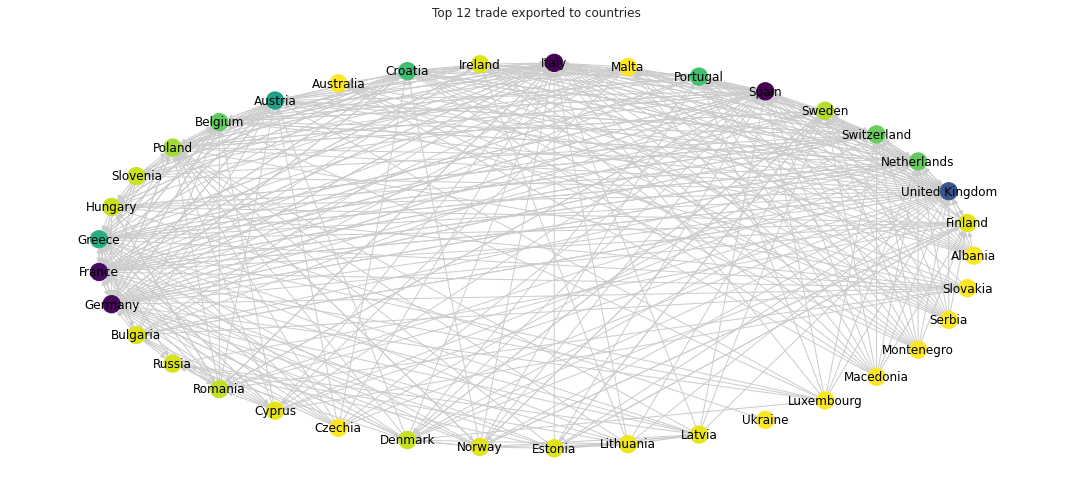

In [ ]:
#  Plotting exapmle of euro trade 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/tour_graph_2014.gpickle")
plot(G,title='Top 12 trade exported to countries',ax=plt.gca())
plt.tight_layout();

#Node2Vec

In [ ]:
!pip install node2vec

In [ ]:
import os
# assign directory
graph_dir = "/content/drive/MyDrive/NLP-SD/Data/graphs"
emb_dir = "/content/drive/MyDrive/NLP-SD/Data/graph_emb/"
for graph_file in os.listdir(graph_dir):
  file_header = graph_file.split(".gpickle")[0]
  if "votes" in graph_file:
    edge_id = "normalized_points"
  else:
    edge_id = "Share"
  G = nx.read_gpickle(os.path.join(graph_dir, graph_file))
  node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs
  model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
  model.wv.save_word2vec_format(emb_dir + "emb_{}.bin".format(file_header))

In [ ]:

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

# Node2Vec Keras Implement (Dont use)

In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
print("Total number of graph nodes euro votes:", g_eurovis.number_of_nodes())
print("Total number of graph edges euro votes:", g_eurovis.number_of_edges())

print("Total number of graph nodes euro trade:", g_trade.number_of_nodes())
print("Total number of graph edges euro trade:", g_trade.number_of_edges())
for v in g_trade:
  if v not in g_eurovis:
    print(v)

In [ ]:
vocabulary = ["NA"] + list(g_eurovis.nodes)
vocabulary_lookup_evision = {token: idx for idx, token in enumerate(vocabulary)}

vocabulary = ["NA"] + list(G.nodes)
vocabulary_lookup_etrade = {token: idx for idx, token in enumerate(vocabulary)}

## Random Walk

In [ ]:
def next_step(graph, previous, current, p, q, w = "weight"):
    neighbors = list(graph.neighbors(current))
    print(neighbors)
    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor][w] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor][w])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor][w] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q, vocabulary_lookup, w = "weight"):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q, w)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

## Generate positive and negative examples

In [ ]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)

In [ ]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

In [ ]:

def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

## Skip-gram model

In [ ]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Node2Vec

In [ ]:
p = 1 # Random walk return parameter.
q = 1 # Random walk in-out parameter.
num_walks = 5 # Number of iterations of random walks.
num_steps = 10 # Number of steps of each random walk.
num_neg_smpls = 4
batch_size = 1024
learning_rate = 0.001
emb_dim = 50
epochs = 10
edge_id = "Share"

def node2vec(graph, edge_id, p, q, vocab, num_walks, num_steps, num_neg_smpls, batch_size, learning_rate, emb_dim, epochs):
  """
  edge_id - is the edge weight identifier. For trades: "Share", for eurovision: "normalized_points"
  """
  # Random walk
  walks = random_walk(graph, num_walks, num_steps, p, q, vocab, edge_id)
  # positive and nagative sampling
  targets, contexts, labels, weights = generate_examples(
      sequences=walks,
      window_size=num_steps,
      num_negative_samples=num_neg_smpls,
      vocabulary_size=len(vocabulary),
  )
  dataset = create_dataset(targets=targets,contexts=contexts,labels=labels,weights=weights,batch_size=batch_size,)
  # skip gram
  model = create_model(len(vocabulary), embedding_dim)
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate),
      loss=keras.losses.BinaryCrossentropy(from_logits=True),
  )
  history = model.fit(dataset, epochs=num_epochs)
  return model

# for testing a single graph
vocabulary = ["NA"] + list(G.nodes)
vocab = {token: idx for idx, token in enumerate(vocabulary)}
model = node2vec(G, edge_id, p, q, vocab, num_walks, num_steps, num_neg_smpls, batch_size, learning_rate, emb_dim, epochs)

In [ ]:
import os
# assign directory
graph_dir = "/content/drive/MyDrive/NLP-SD/Data/graphs"
emb_dir = "/content/drive/MyDrive/NLP-SD/Data/graph_emb/"
for graph_file in os.listdir(graph_dir):
  print("------------------------------")
  print(graph_file)
  print("------------------------------")
  if "votes" in graph_file:
    edge_id = "normalized_points"
  else:
    edge_id = "Share"
  G = nx.read_gpickle(os.path.join(graph_dir, graph_file))
  vocabulary = ["NA"] + list(G.nodes)
  vocab = {token: idx for idx, token in enumerate(vocabulary)}
  model = node2vec(G, edge_id, p, q, vocab, num_walks, num_steps, num_neg_smpls, batch_size, learning_rate, emb_dim, epochs)
  embd = model.get_layer("item_embeddings").get_weights()[0]
  np.savetxt(emb_dir + "emb_{}.txt".format(graph_file), embd, fmt='%d')


In [ ]:
embd = model.get_layer("item_embeddings").get_weights()[0]
np.savetxt('emb_{}_{}.txt', embd, fmt='%d')
b = np.loadtxt('test1.txt', dtype=int)

In [ ]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

In [ ]:
query_movies = [
    "Israel",
    "France",
    "Greece",
    "Italy",
]

In [ ]:
query_embeddings = []

for movie_title in query_movies:
    token_id = vocab[movie_title]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [ ]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [ ]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        # similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_movieId}")
    print()